# Mask maps

## Prerequisites

- Understanding of basic analyses in 1D or 3D.
- Usage of `~regions` and catalogs, see the [catalog notebook](catalog.ipynb). 

## Context

### Fit masks

The region of interest used for the fit can defined through the dataset `mask_fit` attribute.
The `mask_fit` is a map containing boolean values where pixels used in the fit are stored as True.  

2D and 3D analyses usually require to work with a wider map than the region of interest so sources laying outside but reconstructed inside because of the PSF are correcly taken into account. Then the `mask_fit` have to include a margin that take into accout the PSF width. We will show an example in the boundary mask sub-section.

The `mask_fit` also can be used to exclude sources or complex regions for which we don't have good enough models. In that case the masking is an extra security, it is prefereable to include the available models even if the sources are masked and frozen.

Note that a dataset contains also a `mask_safe` attribute that is not meant to be modified directly by users. The  `mask_safe` is defined only from the cuts used in the data reductions (more details [here](https://docs.gammapy.org/dev/makers/index.html#safe-data-range-handling)).

### Exclusion masks

Background templates stored in the DL3 IRF are often not reliable enough to be used without some corrections. A set of common techniques to perform background or normalisation from the data is implemented in gammapy: reflected regions for 1D spectrum analysis, field-of-view (FoV) background or ring background for 2D and 3D analyses.

To avoid contamination of the background estimate from gamma-ray bright regions these methods require to exclude those regions from the data used for the estimation. To do so, we use exclusion masks. They are maps containing boolean values where excluded pixels are stored as False.  


## Proposed approach

Even if the use cases for exclusion masks and fit masks are different, the way to create these masks is exactly the same, so in the following we show how to work with masks in general:
- Creating masks from scratch
- Combining multiple masks
- Extending and reducing an existing mask
- Reading and writing masks


 

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from regions import CircleSkyRegion
from gammapy.maps import Map, WcsGeom
from gammapy.utils.regions import make_region
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.datasets import Datasets
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling.models import FoVBackgroundModel

## Masks creation

### Create the mask from a list of regions

One can build an exclusion mask from regions. We show here how to proceed.

#### Define the geometry

Masks are stored in `Map` objects. We must first define its geometry and then we can determine which pixels to exclude. Here we consider a region at the Galactic anticentre around the crab nebula.

In [3]:
position = SkyCoord(83.633083, 22.0145, unit="deg", frame="icrs")
geom = WcsGeom.create(
    skydir=position, width="5 deg", binsz=0.02, frame="galactic"
)

#### Create the list of regions

We can rely on known sources positions and properties to build a list of regions (here `~regions.SkyRegions`) enclosing most of the signal that our detector would see from these objects.

A useful function to create region objects is `~gammapy.utils.regions.make_region`. It can take strings defining regions following the "ds9" format and convert them to `regions`. 

Here we use a region enclosing the Crab nebula with 0.3 degrees. The actual region size should depend on the expected PSF of the data used. We also add another region with a different shape as en example.

In [4]:
some_region = make_region("galactic;box(185,-4,1.0,0.5, 45)")
crab_region = make_region("icrs;circle(83.633083, 22.0145, 0.3)")
regions = [some_region, crab_region]
print(regions)

[<RectangleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (185., -4.)>, width=1.0 deg, height=0.5 deg, angle=45.0 deg)>, <CircleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (83.633083, 22.0145)>, radius=0.3 deg)>]


Equivalently the regions can be read from a ds9 file, this time using `regions.read_ds9`. 

In [5]:
# regions = read_ds9('ds9.reg')

#### Create the mask map 

We can now create the map. We use the `WcsGeom.region_mask` method putting all pixels inside the regions to False.

In [6]:
# to define the exclusion mask we take the inverse
mask_map = ~geom.region_mask(regions)

(<Figure size 432x288 with 1 Axes>,
 None)

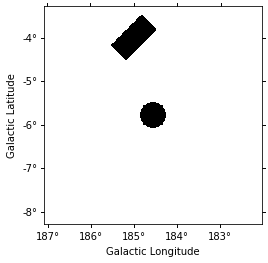

In [7]:
mask_map.plot()

### Create the mask from a catalog of sources

We can also build our list of regions from a list of catalog sources. Here we use the Fermi 4FGL catalog which we read using `~gammapy.catalog.SourceCatalog`.

In [8]:
fgl = CATALOG_REGISTRY.get_cls("4fgl")()

We now select sources that are contained in the region we are interested in.

In [9]:
inside_geom = geom.contains(fgl.positions)
idx = np.where(inside_geom)[0]

We now create the list of regions using our 0.3 degree radius a priori value. If the sources were extended, one would have to adapt the sizes to account for the larger size.

In [10]:
exclusion_radius = Angle("0.3 deg")
regions = [CircleSkyRegion(fgl[i].position, exclusion_radius) for i in idx]

Now we can build the mask map the same way as above.

In [11]:
mask_map_catalog = ~geom.region_mask(regions)

(<Figure size 432x288 with 1 Axes>,
 None)

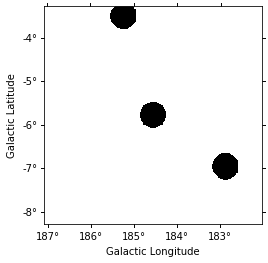

In [12]:
mask_map_catalog.plot()

### Create the mask from statistically significant pixels in a dataset

Here we want to determine an exclusion from the data directly. We will estimate the significance of the data using the `ExcessMapEstimator`, and exclude all pixels above a given threshold.

Here we use a `MapDataset` taken from Fermi data used in the 3FHL catalog. The dataset is already in the form of a `Datasets` object. We read it from disk. 

In [13]:
filename = "$GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_datasets.yaml"
datasets = Datasets.read(filename=filename)
dataset = datasets["Fermi-LAT"]

We now apply a significance estimation. We integrate the counts using a correlation radius of 0.4 degree and apply regular significance estimate. 

In [14]:
estimator = ExcessMapEstimator("0.4 deg", selection_optional=[])
result = estimator.run(dataset)

HDU 'MASK_FIT' not found


Finally, we create the mask map by applying a threshold of 5 sigma to remove pixels.

In [15]:
low_significance_mask = result["sqrt_ts"] < 5.0

Because the `ExcessMapEstimator` returns NaN for masked pixels, we need to put the NaN values to `True` to avoid incorrectly excluding them. 

In [16]:
invalid_pixels = np.isnan(result["sqrt_ts"].data)
high_significance_maskded.data[invalid_pixels] = True

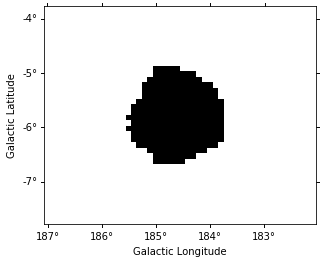

In [17]:
high_significance_maskded.plot();

This method frequently yields isolated pixels or weakly significant features if one places the threshold too low. 

To overcome this issue, one can use `~skimage.filters.apply_hysteresis_threshold` . This filter allows to define two thresholds and mask only the pixels between the low and high thresholds if they are not continuously connected to a pixel above the high threshold. This allows to better preserve the structure of the excesses. 

Note that scikit-image is not a required dependency of gammapy, you might need to install it.


## Masks operations

If two masks share the same geometry it is easy to combine them with `Map` arithmetics.

OR condition is represented by `|` operator :

(<Figure size 432x288 with 1 Axes>,
 None)

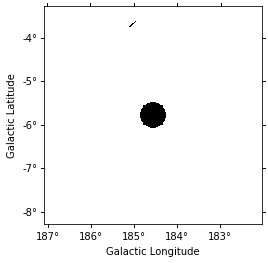

In [18]:
mask = mask_map | mask_map_catalog
mask.plot()


AND condition is represented by `&` or `*` operators :

(<Figure size 432x288 with 1 Axes>,
 None)

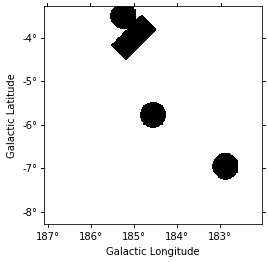

In [19]:
mask_map &= mask_map_catalog
mask_map.plot()

The NOT operator is represented by `~` symbol:

(<Figure size 432x288 with 1 Axes>,
 None)

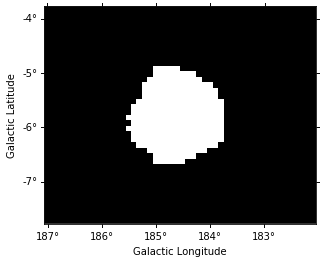

In [20]:
low_significance_maskded = ~high_significance_maskded
low_significance_maskded.plot()

## Mask modifications

### Mask dilation and erosion

One can reduce or extend a mask using `binary_erode` and  `binary_dilate` methods, respectively.

(<Figure size 432x288 with 1 Axes>,
 None)

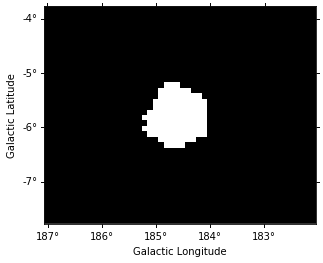

In [21]:
mask = low_significance_maskded.binary_erode(width=0.2 * u.deg, kernel="disk")
mask.plot()

(<Figure size 432x288 with 1 Axes>,
 None)

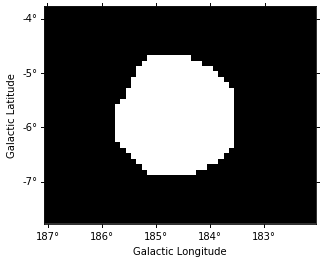

In [22]:
mask = low_significance_maskded.binary_dilate(width=0.2 * u.deg)
mask.plot()

### Boundary mask

In the following example we use the Fermi dataset previously loaded and add its `mask_fit` taking into account a margin based on the psf width. The margin width is determined using the `containment_radius` method of the psf object and the mask is created using the `boundary_mask` method available on the geometry object.

(<Figure size 432x288 with 1 Axes>,
 None)

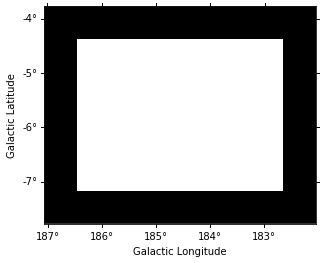

In [23]:
#get PSF 95% containment radius
energy_true = dataset.exposure.geom.axes[0].center
psf_r95 = dataset.psf.containment_radius(fraction=0.95, energy_true=energy_true)
#create mask_fit with margin based on PSF
mask_fit = dataset.counts.geom.boundary_mask(psf_r95.max())
dataset.mask_fit = mask_fit
dataset.mask_fit.sum_over_axes().plot()

## Reading and writing masks

`gammapy.maps` can directly read/write maps with boolean content as follows:

In [24]:
# To save masks to disk
mask_map.write("exclusion_mask.fits", overwrite="True")

In [25]:
# To read maps from disk
mask_map = Map.read("exclusion_mask.fits")